# Figs. 4H, 4K, 4L
# Ext. Data Figs. 6E, 6F
## Responder cells

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
# Typing

from typing import (
    Optional,
    Any,
)
from matplotlib.pyplot import (
    Axes,
)
from numpy.typing import(
    ArrayLike,
)
from pandas import (
    DataFrame,
)

# Others

from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import (
    Rectangle,
)
import matplotlib_venn as venn

from tqdm import tqdm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents
import uncaging.plot as uplot
import uncaging.stats as ustats

#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-4h_4k_4l_s6e_s6f.yaml'
params = uutils.load_params( params_path )

These could be put in the params `.yaml` file if you'd like, but they're the most likely to be modulated so for simplicity let's have them here:

In [3]:
# Choices for `variant`:
# * 'wt_prop'       - Figs. 4H, 4L
# * 'wt_static'     - Fig. S6E
# * 'cx43_prop'     - Fig. 4K
# * 'cx43_static'   - Fig. S6F

variant = 'wt_prop'
params.update( params['variants'][variant] )

#### Initial setup

In [4]:
helper = Helper( config_path = params['helper_configs'],
                 hive_root = params['hive_root'],
                 output_to = params['output_parent'] )

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [5]:
events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = [],
    verbose = True
)

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 22.66it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 30.64it/s]
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 19.14it/s] 



Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99


Experiment GABA
    Excluded cells: 154
    Included cells: 164



In [6]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

### Setup

In [7]:
# These are keys we might need for downstream coregistration
params['responders']['keep_keys'] = [
    'dataset_id',
    'dataset_id_all',
    'condition',
    'mouse',
    'fov',
    'fov_coreg',
    'slice_all',
    'cell_global_all',
    'cell_global_coreg',
]

# Save some duplication in the `responders` params
params['responder_fractions'].update( params['responders'] )

#### TODO: These have duplication with 4M and S7C

#### Statistic functions

In [8]:
def stat_ratio_active( df: DataFrame ) -> float:
    """
    TODO
    """
    return np.sum( df['ratio_active'] ) / df.shape[0]

def stat_ratio_active_diff_paired(
        df1: DataFrame,
        df2: DataFrame,
        pair_key: str = 'dataset_id'
    ) -> float:
    """
    TODO
    """

    groups_1 = df1[pair_key].unique()
    groups_2 = df2[pair_key].unique()
    groups = list( set( groups_1 ) | set( groups_2 ) )
    
    x = []
    y = []
    
    for i, group in enumerate( groups ):
        df1_group = df1[df1[pair_key] == group]
        df2_group = df2[df2[pair_key] == group]
        
        if df1_group.shape[0] == 0 or df2_group.shape[0] == 0:
            continue
        
        x.append( stat_ratio_active( df1_group ) )
        y.append( stat_ratio_active( df2_group ) )
    
    x = np.array( x )
    y = np.array( y )
    
    return np.mean( y - x )

def similarity_jaccard(
        x: ArrayLike,
        y: ArrayLike
    ) -> float:
    """
    TODO
    """
    return np.sum( (x == 1) & (y == 1) ) / np.sum( (x == 1) | (y == 1) )

#### Main analysis

In [9]:
ResponderFractionsResult = 'tuple[dict, dict]'

def responder_fractions(
        df: DataFrame,
        group_key: str,
        groups: list,
        unit_group_key: str = 'cell_global',
        block_key: str = 'dataset_id',
        pair_key: str = 'fov_coreg',
        n_boot: int = 200,
        n_perm: int = 200,
        hierarchy_boot: 'list[str]' = ['dataset_id', 'cell_global'],
        verbose: bool = True,
        **kwargs
    ) -> ResponderFractionsResult:
    
    ret = dict()
    
    stat = stat_ratio_active
    
    # Bootstrapping
    
    for group in groups:
        
        cur_row = dict()
        
        filter_group = df[group_key] == group
        events_group = df[filter_group]
        
        if events_group.shape[0] == 0:
            cur_row = None
            continue
        
        responders_group = uevents.responders(
            events_group,
            unit_group_key,
            **kwargs
        )
        
        frac_active = stat( responders_group )
        
        frac_active_block = []
        for block, df_block in responders_group.groupby( block_key ):
            frac_active_block.append( stat( df_block ) )
        frac_active_block = np.array( frac_active_block )
        
        frac_active_boot = ustats.bootstrap_stat_hierarchical(
            stat,
            responders_group,
            hierarchy_boot,
            n = n_boot,
            verbose = verbose
        )
        
        cur_row['responders'] = responders_group
        cur_row['frac_active'] = frac_active
        cur_row['frac_active_block'] = frac_active_block
        cur_row['frac_active_boot'] = frac_active_boot
        
        ret[group] = cur_row
        
    # Permutation testing
        
    ret_perm = dict()
    
    group_comparisons = list( combinations( groups, 2 ) )
    
    if pair_key is None:
        diff_stat = lambda df1, df2: stat( df2 ) - stat( df1 )
    else:
        diff_stat = lambda df1, df2: stat_ratio_active_diff_paired(
            df1, df2,
            pair_key = pair_key
        )
    
    for group_a, group_b in group_comparisons:
        
        cur_row = dict()
        
        filter_a = df[group_key] == group_a
        events_a = df[filter_a]
        filter_b = df[group_key] == group_b
        events_b = df[filter_b]
        
        responders_a = uevents.responders(
            events_a,
            unit_group_key,
            **kwargs
        )
        responders_b = uevents.responders(
            events_b,
            unit_group_key,
            **kwargs
        )
        
        diff = diff_stat( responders_a, responders_b )
        
        responders_combined = pd.concat( [responders_a, responders_b] )
        
        if verbose:
            it = tqdm( range( n_perm ) )
        else:
            it = range( n_perm )
        
        diff_perm = np.zeros( (n_perm,) )
        for i_perm in it:
            responders_combined_perm = responders_combined.copy()

            if pair_key is None:
                responders_combined_perm[group_key] = np.random.permutation( responders_combined_perm[group_key] )
            
            else:
                for block in responders_combined_perm[block_key].unique():

                    if np.random.uniform() >= 0.5:
                        # Don't flip labels
                        continue

                    filter_a = responders_combined_perm[group_key] == group_a
                    filter_b = responders_combined_perm[group_key] == group_b
                    filter_block = responders_combined_perm[block_key] == block
                    filter_block_a = filter_a & filter_block
                    filter_block_b = filter_b & filter_block

                    responders_combined_perm.loc[filter_block_a, group_key] = group_b
                    responders_combined_perm.loc[filter_block_b, group_key] = group_a
            
            filter_a_perm = responders_combined_perm[group_key] == group_a
            responders_a_perm = responders_combined_perm[filter_a_perm]
            filter_b_perm = responders_combined_perm[group_key] == group_b
            responders_b_perm = responders_combined_perm[filter_b_perm]
            
            diff_perm[i_perm] = diff_stat( responders_a_perm, responders_b_perm )
    
        p_perm = ustats.perm_p( np.sum( np.abs( diff_perm ) >= np.abs( diff ) ),
                                n_perm )
            
        cur_row['diff'] = diff
        cur_row['diff_perm'] = diff_perm
        cur_row['p_perm'] = p_perm
        
        ret_perm[group_a, group_b] = cur_row
    
    return ret, ret_perm

def active_comparison_stats(
        results,
        n_perm: int = 10000
    ):
    """
    TODO
    """
    
    ret = dict()
    
    comparison_keys = [k for k in results.keys()
                       if 'ratio_active' in k]
    
    for comparison in list( combinations( comparison_keys, 2 ) ):
        
        cur_ret = dict()
        
        x = results[comparison[0]]
        y = results[comparison[1]]
        
        print( comparison )
        
        cur_ret['spearman'] = scipy.stats.spearmanr( x, y )
        cur_ret['spearman_p'] = cur_ret['spearman'].pvalue
        print( f'    Spearman: {scipy.stats.spearmanr( x, y )}' )
        
        spearman_perm = np.zeros( (n_perm,) )
        for i_perm in tqdm( range( n_perm ) ):
            x_perm = np.random.permutation( x )
            y_perm = np.random.permutation( y )
            spearman_perm[i_perm] = scipy.stats.spearmanr( x_perm, y_perm )[0]
        cur_ret['spearman_perm'] = spearman_perm
        cur_ret['spearman_p_perm'] = ustats.perm_p( np.sum( np.abs( spearman_perm ) >= np.abs( cur_ret['spearman'][0] ) ), n_perm )
        print( f'    Spearman p (perm): {cur_ret["spearman_p_perm"]}' )
        
        plt.figure( figsize = (4, 3) )
        plt.hist( spearman_perm, bins = np.arange( -0.55, 0.56, 0.1 ) )
        yl = plt.ylim()
        plt.plot( [cur_ret['spearman'][0], cur_ret['spearman'][0]], yl, 'k-', linewidth = 2 )
        plt.show()
        
        #
        
        jaccard = similarity_jaccard( x, y )
        cur_ret['jaccard'] = jaccard
        
        jaccard_perm = np.zeros( (n_perm,) )
        for i_perm in tqdm( range( n_perm ) ):
            x_perm = np.random.permutation( x )
            y_perm = np.random.permutation( y )
            jaccard_perm[i_perm] = similarity_jaccard( x_perm, y_perm )
        cur_ret['jaccard_perm'] = jaccard_perm
        cur_ret['jaccard_p_perm'] = ustats.perm_p( np.sum( jaccard_perm >= jaccard ), n_perm )
        print( f'    Jaccard: {jaccard}' )
        print( f'    Jaccard p (perm): {cur_ret["jaccard_p_perm"]}' )
        
        plt.figure( figsize = (4, 3) )
        plt.hist( jaccard_perm, bins = 10 )
        yl = plt.ylim()
        plt.plot( [jaccard, jaccard], yl, 'k-', linewidth = 2 )
        plt.show()
        
        ret[comparison] = cur_ret
    
    return ret

#### Plotting

In [10]:
def responder_fraction_plot(
        ax: Axes,
        results: ResponderFractionsResult,
        # TODO This formulation gets rid of the order information!
        spec: 'dict[str, Any]',
        std_block: float = 0.15,
        block_offset: float = 0.01,
        quantile: Optional[float] = 0.05
    ):
    """
    TODO
    """
    
    x_ticks = []
    x_tick_labels = []
    
    for i_group, (group, color) in enumerate( spec.items() ):
        
        frac_active = results[group]['frac_active']
        ax.bar( i_group, frac_active,
                color = color )
        
        x_ticks.append( i_group )
        x_tick_labels.append( group )
        
        y_block = block_offset + results[group]['frac_active_block']
        x_block = i_group + std_block * np.random.normal( size = y_block.shape )
        ax.plot( x_block, y_block, 'k.',
                 markersize = 5,
                 alpha = 0.33 )
        
        if quantile is None:
            frac_active_sem = np.std( results[group]['frac_active_boot'] )
            frac_active_low = frac_active - frac_active_sem
            frac_active_high = frac_active + frac_active_sem
        else:
            frac_active_low = np.quantile( results[group]['frac_active_boot'], quantile/2. )
            frac_active_high = np.quantile( results[group]['frac_active_boot'], 1. - (quantile/2.) )
        
        ax.plot( [i_group, i_group], [frac_active_low, frac_active_high],
                 'k-',
                 linewidth = 2 )
    
    ax.set_ylim( 0, 1.45 )
    ax.set_ylabel( 'Fraction of neighbor cells responding' )
    ax.set_yticks( np.arange( 0., 1.01, 0.2 ) )
    
    ax.set_xticks( x_ticks )
    ax.set_xticklabels( x_tick_labels )

def significance_plot(
        ax: Axes,
        p_comparison,
        group_xs: 'dict[str, float]',
        start = 1.,
        spacing = 0.1
    ):
    """
    TODO
    """

    for i_comparison, (comparison, p) in enumerate( p_comparison.items() ):
        group_a = comparison[0]
        group_b = comparison[1]
        
        # i_a = [x[0] for x in spec].index( group_a )
        # i_b = [x[0] for x in spec].index( group_b )
        
        # x_a = spec[i_a][1]
        # x_b = spec[i_b][1]
        
        x_a = group_xs[comparison[0]]
        x_b = group_xs[comparison[1]]

        y = start + spacing * i_comparison
        
        ax.plot( [x_a, x_b], [y, y], 'k-', linewidth = 2 )
        ax.text( (x_a + x_b)/2, y + spacing * 0.2, uutils.p_text( p ),
                 horizontalalignment = 'center',
                 verticalalignment = 'baseline' )

def active_comparison_plot(
        ax: Axes,
        results,
        colors: 'dict[str, Any]' = {'Glu': 'b', 'GABA': 'm'}
    ):
    """
    TODO
    """
    
    comparison_keys = [k for k in results.keys()
                       if 'ratio_active' in k]
    comparisons = [k.split( '_' )[-1]
                   for k in comparison_keys]
    
    data = np.array( results[comparison_keys] ).T
    
    for i in range( data.shape[0] ):
        for j in range( data.shape[1] ):
            if data[i, j] > 0:
                rect = Rectangle(
                    (j, i), 1, 1,
                    linewidth = 0,
                    facecolor = colors[comparisons[i]],
                    alpha = 0.6
                )
                ax.add_patch( rect )
                
    ax.set_xlim( 0, data.shape[1] )
    ax.set_ylim( 0, data.shape[0] )
    
    ax.set_yticks( 0.5 + np.arange( len( comparisons ) ) )
    ax.set_yticklabels( comparisons )

# TODO Somewhat not generalizeable
def active_comparison_plot_venn( ax, results,
                                 colors = None ):
    
    if colors is None:
        colors = helper.condition_colors
    
    comparison_keys = [k for k in results.keys()
                       if 'ratio_active' in k]
    comparisons = [k.split( '_' )[-1]
                   for k in comparison_keys]
    
    data_a = np.array( results[comparison_keys[0]] ).T
    data_b = np.array( results[comparison_keys[1]] ).T
    
    n_total = results.shape[0]
    n_a = np.sum( data_a )
    n_b = np.sum( data_b )
    n_ab = np.sum( (data_a == 1) & (data_b == 1) )
    
    venn_tuple = ( n_total - (n_a - n_ab) - (n_b - n_ab) - n_ab, # Abc
                   0,          # aBc
                   n_a - n_ab, # ABc
                   0,          # abC
                   n_b - n_ab, # AbC
                   0,          # aBC
                   n_ab,       # ABC
                 )
    
    set_labels = ( 'Baseline-active neighbors',
                   f'{comparisons[0]} responders',
                   f'{comparisons[1]} responders',
                 )
    
    venn.venn3( venn_tuple,
                set_labels = set_labels,
                ax = ax )

### Run

In [11]:
comparison_key = params['comparison_key']
comparison_groups = params['comparison']

if params['event_type'].lower().startswith( 'prop' ):
    events_subset = events_prop.copy()
elif params['event_type'].lower().startswith( 'static' ):
    events_subset = events_no_prop.copy()
elif params['event_type'].lower().startswith( 'all' ):
    events_subset = events_analyze.copy()
else:
    raise ValueError( f'Unrecognized event type: {params["event_type"]}' )

filter_events_condition = events_subset[comparison_key].isin( comparison_groups )
filter_events_neighbor = events_subset['is_uncage'] == False
filter_events_panel = filter_events_condition & filter_events_neighbor

events_panel = events_subset.copy()[filter_events_panel]

#### Characterize $n$

In [12]:
uevents.summarize_n( events_panel )

Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 250
Cells:           n = 167
Events:          n = 2470
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  1
    High: 52

** GABA:
Datasets:        n = 28
Cell-recordings: n = 135
Events:          n = 1358
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 115
Events:          n = 1112
Cells per dataset:
    Low:  1
    High: 7


#### Responders

In [13]:
results, results_perm = responder_fractions(
    events_panel,
    params['comparison_key'], params['comparison'],
    **params['responder_fractions']
)

p_comparison = { comparison: result['p_perm']
                 for comparison, result in results_perm.items() }

100%|██████████| 10000/10000 [00:06<00:00, 1512.19it/s]


#### Overlap

In [14]:
events_considered = events_prop.copy()
filter_events_neighbor = events_considered['is_uncage'] == False

responders_per_condition = []

for condition in params['comparison']:
    
    filter_events_condition = events_considered['condition'] == condition
    filter_events_cur = filter_events_neighbor & filter_events_condition
    
    events_cur = events_considered[filter_events_cur]
    
    responders_cur = uevents.responders(
        events_cur,
        params['overlap_responder_key'],
        **params['responders']
    )
    responders_per_condition.append( responders_cur[[
        'mouse',
        'slice_all',
        'dataset_id_all',
        'cell_global_coreg',
        'ratio_active',
    ]] )

responders_suffixes = [ f'_{x}'
                        for x in params['comparison'] ]
responders_overall = pd.merge(
    responders_per_condition[0], responders_per_condition[1],
    on = 'cell_global_coreg',
    how = 'inner',
    suffixes = responders_suffixes,
) 

#### Save results

In [15]:
save_dict = {
    'events_panel': events_panel,
    'params': params,
    'results': results,
    'p_comparison': p_comparison,
}

save_data( 'response-fraction-prop', **save_dict )

#### Validation: Bootstrap distributions

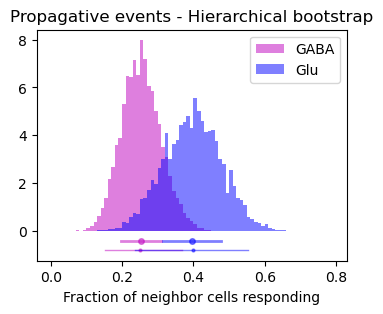

In [16]:
# TODO Dynamically determine bin bounds
bins = np.arange( 0., 0.8, 0.01 )

fig, ax = plt.subplots( figsize = (4, 3) )

for condition in params['comparison']:
    
    color = helper.condition_colors[condition]
    result = results[condition]
    
    uplot.plot_boot(
        ax,
        result['frac_active_boot'],
        result['frac_active'],
        color = color,
        bins = bins,
        label = condition
    )

plt.legend()
plt.title( f'{params["event_type_label"]} events - Hierarchical bootstrap' )
plt.xlabel( 'Fraction of neighbor cells responding' )
    
plt.show()

#### Validation: Permutation distributions

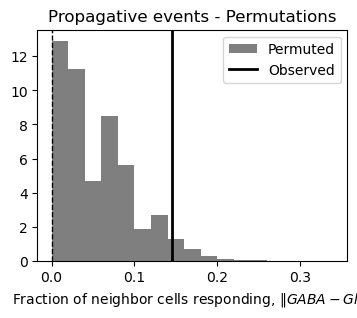

In [17]:
# TODO Dynamically determine bin bounds
bins = np.arange( 0, 0.35, 0.02 )

for comparison, result in results_perm.items():
    
    fig, ax = plt.subplots( figsize = (4, 3) )
    
    uplot.plot_perm(
        ax,
        np.abs( result['diff_perm'] ),
        np.abs( result['diff'] ),
        color = 'k',
        bins = bins
    )
    
    plt.legend()
    plt.title( f'{params["event_type_label"]} events - Permutations' )
    plt.xlabel( 'Fraction of neighbor cells responding, $\|GABA - Glu\|$' )
    
    plt.show()

#### Result: Responder fractions

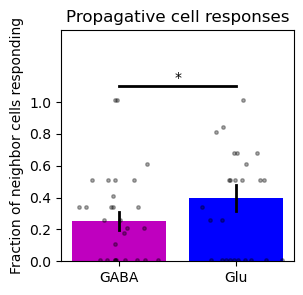

GABA
Analyzed cells:                   99
Without baseline events:          0
Fraction without baseline events: 0.0

Glu
Analyzed cells:                   78
Without baseline events:          0
Fraction without baseline events: 0.0

GABA vs. Glu:
    {('GABA', 'Glu'): 0.0491950804919508}


In [18]:
if 'responder_fraction_plot' in params['output_names'].keys():
    
    fig, ax = plt.subplots( figsize = ( 3, 3) )

    plot_spec = { g: helper.condition_colors[g]
                for g in params['comparison'] }
    responder_fraction_plot(
        ax,
        results,
        plot_spec,
        **params['responder_fraction_plot']
    )

    group_xs = { g: i
                for i, g in enumerate( params['comparison'] ) }
    significance_plot(
        ax,
        p_comparison,
        group_xs,
        **params['significance_plot']
    )

    ax.set_title( f'{params["event_type_label"]} cell responses' )

    save_figure( params['output_names']['responder_fraction_plot'] )

    plt.show()

    for condition, results_condition in results.items():
        print( condition )
        print( '=======' )
        print( f"Analyzed cells:                   {results_condition['responders'].shape[0]}" )
        print( f"Without baseline events:          {np.sum( results_condition['responders']['rate_pre'] == 0 )}" )
        print( f"Fraction without baseline events: {1 - np.sum( results_condition['responders']['rate_pre'] > 0 ) / results_condition['responders'].shape[0]}" )
        print()

    print( f"{comparison[0]} vs. {comparison[1]}:" )
    print( f'    {p_comparison}' )

    

#### Result: Response overlap

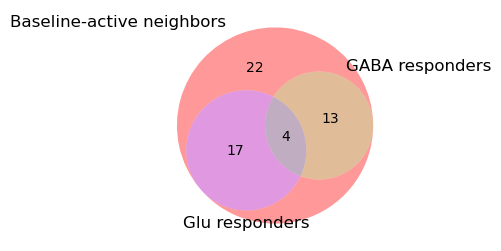

In [19]:
if 'active_comparison_plot_venn' in params['output_names'].keys():
    
    fig, ax = plt.subplots( figsize = (6, 3) )

    active_comparison_plot_venn( ax, responders_overall )

    save_figure( params['output_names']['active_comparison_plot_venn'] )
    
    plt.show()